In [89]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import yfinance as yf
from typing import Dict, Tuple, Optional, List, Union
from dataclasses import dataclass
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

@dataclass
class EventStudyConfig:
    """Configuration settings for event study analysis"""
    days_before: int = 30
    days_after: int = 30
    base_path: str = "alle data fixed"
    significance_colors: Dict[str, Tuple[str, float]] = None
    
    def __post_init__(self):
        if self.significance_colors is None:
            self.significance_colors = {
                'highly_significant': ('#00FF00', 0.3),  # Bright green
                'significant': ('#FF8C00', 0.3),        # Dark orange
                'weakly_significant': ('#FFA500', 0.3), # Orange
                'not_significant': ('#FF4500', 0.3)     # Red
            }

class DataLoader:
    def __init__(self, base_path: str):
        self.base_path = Path(base_path)
        self.stock_data = {}
        self.company_map = None
        self.missing_files = set()
        self._load_company_mapping()
    
    def _load_company_mapping(self):
        mapping_path = self.base_path / "Stock names and countries.xlsx"
        self.company_map = pd.read_excel(mapping_path).drop('Unnamed: 0', axis=1)
    
    def _load_company_files(self, conid: str, ticker: str) -> Optional[Tuple[pd.DataFrame, pd.DataFrame]]:
        try:
            price_data = pd.read_csv(self.base_path / f"{conid}_DATA.csv")
            dividend_data = pd.read_csv(self.base_path / f"{conid}_WHS.csv")
            
            price_data = self._process_price_data(price_data)
            dividend_data = self._process_dividend_data(dividend_data)
            
            return price_data, dividend_data
            
        except FileNotFoundError:
            if ticker not in self.missing_files:
                print(f"Warning: Data files not found for {ticker} (ConID: {conid}). Skipping...")
                self.missing_files.add(ticker)
            return None
        except Exception as e:
            if ticker not in self.missing_files:
                print(f"Error processing data for {ticker} (ConID: {conid}): {str(e)}. Skipping...")
                self.missing_files.add(ticker)
            return None
    
    def _process_price_data(self, df: pd.DataFrame) -> pd.DataFrame:
        correct_columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 
                         'NumberOfTrades', 'VWAP', 'IM_Open', 'IM_High', 'IM_Low', 
                         'IM_Close', 'SV_Open', 'SV_Open.1', 'SV_Open.2', 'SV_Open.3']
        
        df = df.iloc[:, :-1]
        df.columns = correct_columns
        df = df.reset_index(drop=True)
        df['Date'] = pd.to_datetime(df['Date'])
        
        df['Return'] = df['Close'].pct_change()
        
        sp500 = yf.download('^GSPC', start=df['Date'].min(), end=df['Date'].max())
        sp500['Return'] = sp500['Close'].pct_change()
        
        df = df.merge(sp500['Return'], left_on='Date', right_index=True, 
                     how='left', suffixes=('', '_SP500'))
        df['Excess_Return'] = df['Return'] - df['Return_SP500']
        
        return df
    
    def _process_dividend_data(self, df: pd.DataFrame) -> pd.DataFrame:
        df = df.iloc[:,1:-4]
        df = df.reset_index(drop=True)
        
        date_columns = ['announce_date', 'record_date', 'ex_div_date', 'pay_date']
        for col in date_columns:
            if col == 'announce_date':
                df[col] = pd.to_datetime(df[col])
            else:
                df[col] = pd.to_datetime(df[col].astype(str).str.slice(-8), format='%Y%m%d')
        
        return df
    
    def get_company_data(self, ticker: str) -> Optional[Tuple[pd.DataFrame, pd.DataFrame]]:
        if ticker in self.stock_data:
            return self.stock_data[ticker]
            
        company_row = self.company_map[self.company_map['Name'] == ticker.upper()]
        if company_row.empty:
            print(f"Warning: Company {ticker} not found in mapping file. Skipping...")
            return None
        
        conid = str(company_row['ConID'].iloc[0])
        result = self._load_company_files(conid, ticker)
        
        if result is not None:
            self.stock_data[ticker] = result
            
        return result

class EventStudyAnalysis:
    def __init__(self, config: EventStudyConfig):
        self.config = config
        self.data_loader = DataLoader(config.base_path)
    
    def prepare_event_data(self, tickers: List[str], event_type: str) -> pd.DataFrame:
        all_event_data = []
        processed_tickers = []
        
        for ticker in tickers:
            data = self.data_loader.get_company_data(ticker)
            if data is None:
                continue
                
            price_data, dividend_data = data
            processed_tickers.append(ticker)
            
            for event_date in dividend_data[event_type]:
                window_start = event_date - pd.Timedelta(days=self.config.days_before)
                window_end = event_date + pd.Timedelta(days=self.config.days_after)
                
                event_window = price_data[
                    (price_data['Date'] >= window_start) & 
                    (price_data['Date'] <= window_end)
                ].copy()
                
                if len(event_window) > 0:
                    event_window['days_from_event'] = (
                        event_window['Date'] - event_date).dt.days
                    event_window['stock'] = ticker
                    event_window['event_date'] = event_date
                    all_event_data.append(event_window)
        
        if not all_event_data:
            raise ValueError("No valid event data found for any of the specified tickers")
        
        if processed_tickers:
            print(f"\nSuccessfully processed {len(processed_tickers)} companies: {', '.join(processed_tickers)}")
            
        return pd.concat(all_event_data, ignore_index=True)
    
    def analyze_event_window(self, event_data: pd.DataFrame) -> pd.DataFrame:
        """Calculate daily statistics for event window"""
        from scipy import stats as scipy_stats
        
        grouped = event_data.groupby('days_from_event')
        
        daily_stats = pd.DataFrame()
        daily_stats['days_from_event'] = grouped['days_from_event'].first()
        daily_stats['mean'] = grouped['Excess_Return'].mean()
        daily_stats['std'] = grouped['Excess_Return'].std()
        daily_stats['n'] = grouped['Excess_Return'].count()
        
        daily_stats = daily_stats.reset_index(drop=True)
        
        daily_stats['t_stat'] = np.where(
            daily_stats['std'] > 0,
            daily_stats['mean'] / (daily_stats['std'] / np.sqrt(daily_stats['n'])),
            0
        )
        
        daily_stats['p_value'] = 2 * (1 - scipy_stats.t.cdf(
            np.abs(daily_stats['t_stat']), 
            df=daily_stats['n'] - 1
        ))
        
        return daily_stats
    
    def plot_event_study(self, daily_stats: pd.DataFrame, title: Optional[str] = None) -> plt.Figure:
        fig, ax = plt.subplots(figsize=(12, 6))
        
        ci_upper = daily_stats['mean'] + daily_stats['std']
        ci_lower = daily_stats['mean'] - daily_stats['std']
        
        ax.fill_between(daily_stats['days_from_event'], ci_lower, ci_upper,
                       color='blue', alpha=0.1)
        ax.plot(daily_stats['days_from_event'], daily_stats['mean'],
               color='blue', linewidth=2, label='Mean Excess Return')
        
        for _, row in daily_stats.iterrows():
            p_val = row['p_value']
            if p_val < 0.01:
                color, alpha = self.config.significance_colors['highly_significant']
            elif p_val < 0.05:
                color, alpha = self.config.significance_colors['significant']
            elif p_val < 0.1:
                color, alpha = self.config.significance_colors['weakly_significant']
            else:
                color, alpha = self.config.significance_colors['not_significant']
            
            ax.axvspan(row['days_from_event'] - 0.5,
                      row['days_from_event'] + 0.5,
                      facecolor=color,
                      alpha=alpha,
                      edgecolor='none')
        
        ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
        ax.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
        
        ax.set_title(title or 'Event Study: Mean Excess Returns',
                    fontsize=12, pad=15)
        ax.set_xlabel('Days from Event', fontsize=10)
        ax.set_ylabel('Excess Return', fontsize=10)
        ax.set_xlim(-self.config.days_before, self.config.days_after)
        
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor='#00FF00', alpha=0.3, label='*** p < 0.01'),
            Patch(facecolor='#FF8C00', alpha=0.3, label='** p < 0.05'),
            Patch(facecolor='#FFA500', alpha=0.3, label='* p < 0.1'),
            Patch(facecolor='#FF4500', alpha=0.3, label='Not significant')
        ]
        ax.legend(handles=legend_elements, loc='center left', 
                 bbox_to_anchor=(1, 0.5))
        
        plt.tight_layout()
        return fig

def print_significant_results(daily_stats: pd.DataFrame) -> None:
    print("\nHighly Significant Results (p < 0.01):")
    print("=" * 50)
    
    significant = daily_stats[daily_stats['p_value'] < 0.01].copy()
    if significant.empty:
        print("No highly significant results found")
        return
        
    significant['mean_pct'] = significant['mean'] * 100
    significant['ci_lower'] = (significant['mean'] - significant['std']) * 100
    significant['ci_upper'] = (significant['mean'] + significant['std']) * 100
    
    significant = significant.sort_values('days_from_event')
    
    for _, row in significant.iterrows():
        print(f"Day {int(row['days_from_event'])}: {row['mean_pct']:.2f}% [{row['ci_lower']:.2f}%, {row['ci_upper']:.2f}%]")
        print(f"  t-stat: {row['t_stat']:.2f}, p-value: {row['p_value']:.4f}")
        print("-" * 50)

def run_event_study(tickers: Union[List[str], str], 
                   event_type: str, 
                   data_loader: DataLoader,
                   days_before: int = 30, 
                   days_after: int = 30,
                   title: Optional[str] = None) -> Optional[Tuple[plt.Figure, pd.DataFrame]]:
    try:
        config = EventStudyConfig(
            days_before=days_before, 
            days_after=days_after,
            base_path=data_loader.base_path
        )
        
        analysis = EventStudyAnalysis(config)
        analysis.data_loader = data_loader
        
        if isinstance(tickers, str) and tickers.upper() == 'ALL':
            tickers = analysis.data_loader.company_map['Name'].tolist()
            print(f"Attempting to analyze all {len(tickers)} available companies...")
        
        event_data = analysis.prepare_event_data(tickers, event_type)
        daily_stats = analysis.analyze_event_window(event_data)
        
        if title is None:
            if isinstance(tickers, str) and tickers.upper() == 'ALL':
                title = f'Event Study: {event_type} (All Available Companies)'
            else:
                title = f'Event Study: {event_type} for Available Companies'
        
        fig = analysis.plot_event_study(daily_stats, title)
        
        print(f"\nEvent Study Summary ({event_type}):")
        print(f"Number of events: {len(event_data['event_date'].unique())}")
        print(f"Number of companies: {len(event_data['stock'].unique())}")
        
        print_significant_results(daily_stats)
        
        return fig, daily_stats
        
    except ValueError as e:
        print(f"\nError: {str(e)}")
        return None
    except Exception as e:
        print(f"\nUnexpected error: {str(e)}")
        print(f"Error details: {type(e).__name__}")
        return None
def analyze_stocks_events(tickers: Union[str, List[str]], data_loader: DataLoader = None) -> None:
    """
    Perform event study analysis for specified stocks across all event types.
    
    Parameters:
    -----------
    tickers : str or list of str
        Either 'ALL' for all stocks, or a list of stock tickers to analyze
    data_loader : DataLoader, optional
        DataLoader instance. If None, creates a new one
        
    Example usage:
    -------------
    # For a single stock:
    analyze_stocks_events('AAPL')
    
    # For multiple specific stocks:
    analyze_stocks_events(['AAPL', 'MSFT', 'GOOGL'])
    
    # For all available stocks:
    analyze_stocks_events('ALL')
    """
    # Initialize data loader if not provided
    if data_loader is None:
        data_loader = DataLoader("alle data fixed")
    
    # Convert single ticker to list
    if isinstance(tickers, str) and tickers != 'ALL':
        tickers = [tickers]
    
    # Get ticker description for titles
    ticker_desc = 'All Companies' if tickers == 'ALL' else ', '.join(tickers)
    
    # Define event types
    event_types = ['record_date', 'announce_date', 'ex_div_date', 'pay_date']
    
    # Run analysis for each event type
    for event_type in event_types:
        print(f"\nAnalyzing {event_type.replace('_', ' ').title()} for {ticker_desc}...")
        result = run_event_study(
            tickers=tickers,
            event_type=event_type,
            data_loader=data_loader,
            title=f'Event Study: {event_type.replace("_", " ").title()} ({ticker_desc})'
        )
        if result:
            fig, stats = result
            plt.show()
        print("\n" + "="*80 + "\n")

These are all the companies we can research:

NKE, WFC, RAND, PG, USB, ASML, PHARM, UNH, OCI, CRBN, WMT, JPM, BRNL, IMCD, NN, WBA, ABN, LIGHT, ASRNL, BFIT, AD, INGA, TKWY, EXO, AAPL, AAPL, AMGN, CSCO, INTC, MSFT, COST, MT, ASM, HEIA, KPN, PHIA, CRM, ALFEN, BESI, URW, ADYEN, REN, GLPG, AKZA, DOW, PRX, BAMNB, WKL, SBMO, HBI, UNA, JDEP, TRV, HON, SLIGR, TWEKA, AALB, LUMN, AMG, GS, INPST, AXP, BA, VZ, FUR, V, ARCAD, ECMPA, SHELL, CAT, CVX, DSM, AF, AF, AGN, AGN, EPD, HEIJM, MRK, VPK, DVN, HD, APAM, IBM, JNJ, PNL, KO, MCD, MMM

Analyzing all the stocks that we have acces to


Analyzing Record Date for All Companies...
Attempting to analyze all 92 available companies...

Successfully processed 89 companies: NKE, WFC, RAND, PG, USB, ASML, PHARM, UNH, OCI, CRBN, WMT, JPM, BRNL, IMCD, NN, WBA, ABN, LIGHT, ASRNL, BFIT, AD, INGA, TKWY, EXO, AAPL, AAPL, AMGN, CSCO, INTC, MSFT, COST, MT, ASM, HEIA, KPN, PHIA, CRM, ALFEN, BESI, URW, ADYEN, REN, GLPG, AKZA, DOW, PRX, BAMNB, WKL, SBMO, HBI, UNA, JDEP, TRV, HON, SLIGR, TWEKA, AALB, LUMN, AMG, GS, INPST, AXP, BA, VZ, FUR, V, ARCAD, ECMPA, SHELL, CAT, CVX, DSM, AF, AF, AGN, AGN, EPD, HEIJM, MRK, VPK, DVN, HD, APAM, IBM, JNJ, PNL, KO, MCD, MMM

Event Study Summary (record_date):
Number of events: 672
Number of companies: 77

Highly Significant Results (p < 0.01):
Day -18: -0.17% [-1.86%, 1.51%]
  t-stat: -2.92, p-value: 0.0036
--------------------------------------------------
Day -3: -0.41% [-2.25%, 1.44%]
  t-stat: -6.22, p-value: 0.0000
--------------------------------------------------
Day -1: -1.16% [-3.06%, 0.75%]


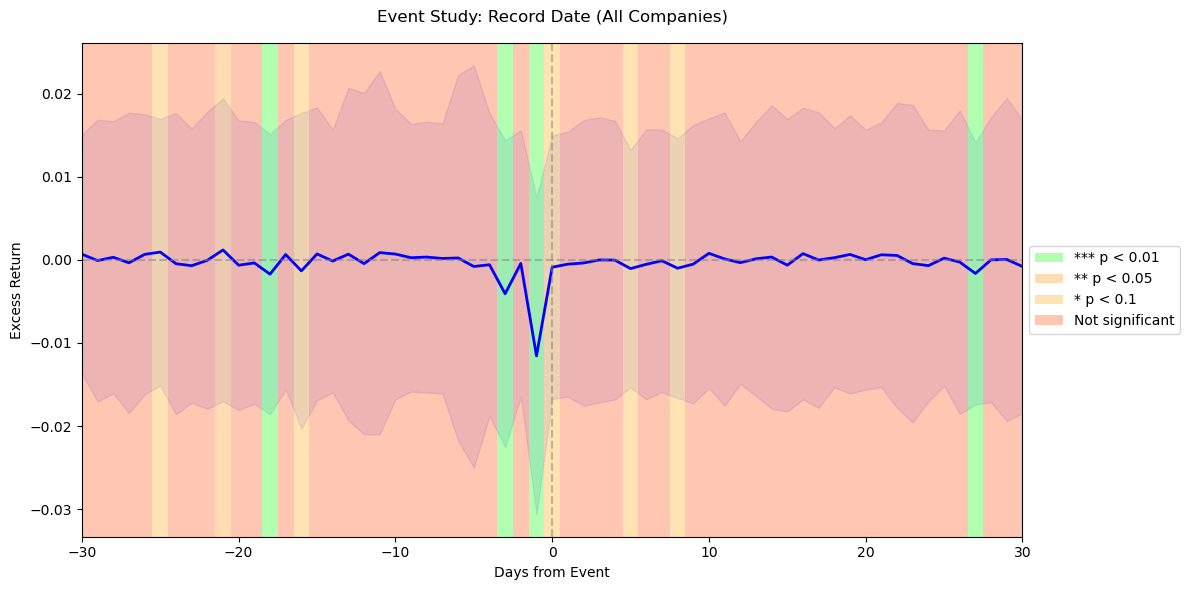




Analyzing Announce Date for All Companies...
Attempting to analyze all 92 available companies...

Successfully processed 89 companies: NKE, WFC, RAND, PG, USB, ASML, PHARM, UNH, OCI, CRBN, WMT, JPM, BRNL, IMCD, NN, WBA, ABN, LIGHT, ASRNL, BFIT, AD, INGA, TKWY, EXO, AAPL, AAPL, AMGN, CSCO, INTC, MSFT, COST, MT, ASM, HEIA, KPN, PHIA, CRM, ALFEN, BESI, URW, ADYEN, REN, GLPG, AKZA, DOW, PRX, BAMNB, WKL, SBMO, HBI, UNA, JDEP, TRV, HON, SLIGR, TWEKA, AALB, LUMN, AMG, GS, INPST, AXP, BA, VZ, FUR, V, ARCAD, ECMPA, SHELL, CAT, CVX, DSM, AF, AF, AGN, AGN, EPD, HEIJM, MRK, VPK, DVN, HD, APAM, IBM, JNJ, PNL, KO, MCD, MMM

Event Study Summary (announce_date):
Number of events: 674
Number of companies: 77

Highly Significant Results (p < 0.01):
Day -1: 0.14% [-1.46%, 1.73%]
  t-stat: 2.76, p-value: 0.0059
--------------------------------------------------
Day 8: -0.19% [-1.92%, 1.54%]
  t-stat: -3.49, p-value: 0.0005
--------------------------------------------------
Day 9: -0.28% [-2.19%, 1.64%]

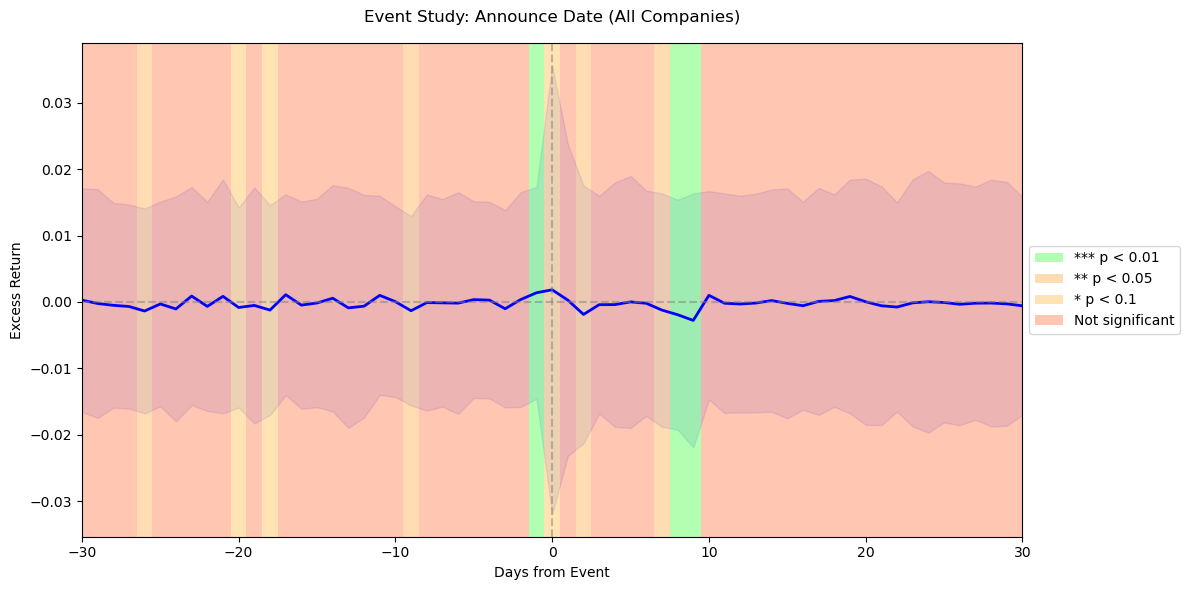




Analyzing Ex Div Date for All Companies...
Attempting to analyze all 92 available companies...

Successfully processed 89 companies: NKE, WFC, RAND, PG, USB, ASML, PHARM, UNH, OCI, CRBN, WMT, JPM, BRNL, IMCD, NN, WBA, ABN, LIGHT, ASRNL, BFIT, AD, INGA, TKWY, EXO, AAPL, AAPL, AMGN, CSCO, INTC, MSFT, COST, MT, ASM, HEIA, KPN, PHIA, CRM, ALFEN, BESI, URW, ADYEN, REN, GLPG, AKZA, DOW, PRX, BAMNB, WKL, SBMO, HBI, UNA, JDEP, TRV, HON, SLIGR, TWEKA, AALB, LUMN, AMG, GS, INPST, AXP, BA, VZ, FUR, V, ARCAD, ECMPA, SHELL, CAT, CVX, DSM, AF, AF, AGN, AGN, EPD, HEIJM, MRK, VPK, DVN, HD, APAM, IBM, JNJ, PNL, KO, MCD, MMM

Event Study Summary (ex_div_date):
Number of events: 660
Number of companies: 77

Highly Significant Results (p < 0.01):
Day 0: -1.20% [-3.09%, 0.69%]
  t-stat: -21.05, p-value: 0.0000
--------------------------------------------------


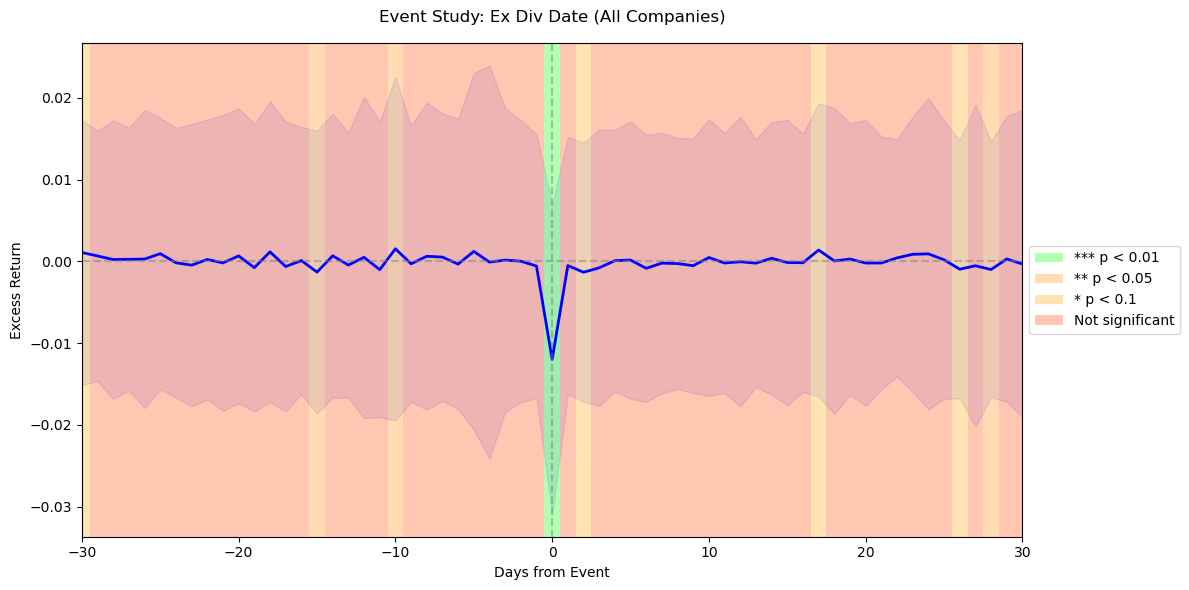




Analyzing Pay Date for All Companies...
Attempting to analyze all 92 available companies...

Successfully processed 89 companies: NKE, WFC, RAND, PG, USB, ASML, PHARM, UNH, OCI, CRBN, WMT, JPM, BRNL, IMCD, NN, WBA, ABN, LIGHT, ASRNL, BFIT, AD, INGA, TKWY, EXO, AAPL, AAPL, AMGN, CSCO, INTC, MSFT, COST, MT, ASM, HEIA, KPN, PHIA, CRM, ALFEN, BESI, URW, ADYEN, REN, GLPG, AKZA, DOW, PRX, BAMNB, WKL, SBMO, HBI, UNA, JDEP, TRV, HON, SLIGR, TWEKA, AALB, LUMN, AMG, GS, INPST, AXP, BA, VZ, FUR, V, ARCAD, ECMPA, SHELL, CAT, CVX, DSM, AF, AF, AGN, AGN, EPD, HEIJM, MRK, VPK, DVN, HD, APAM, IBM, JNJ, PNL, KO, MCD, MMM

Event Study Summary (pay_date):
Number of events: 671
Number of companies: 77

Highly Significant Results (p < 0.01):
Day -23: -0.25% [-1.92%, 1.42%]
  t-stat: -4.02, p-value: 0.0001
--------------------------------------------------
Day -12: -0.25% [-2.13%, 1.62%]
  t-stat: -3.13, p-value: 0.0018
--------------------------------------------------


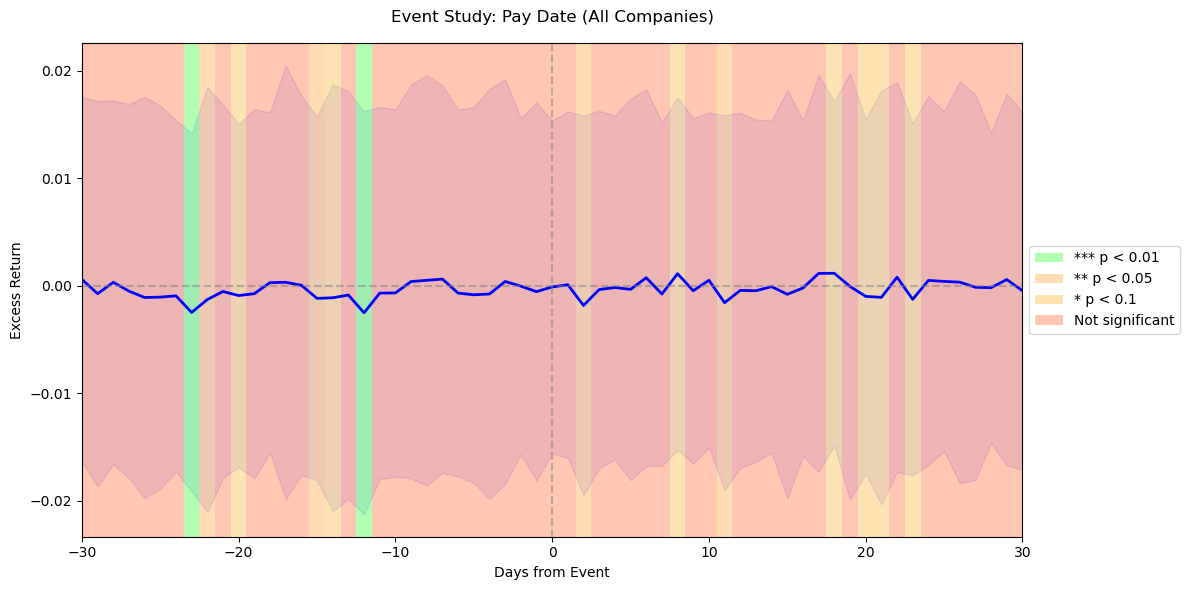

In [97]:
all_stocks = 'ALL'
analyze_stocks_events(all_stocks, data_loader=global_loader)

Create industry-specific stock baskets and analyze dividend event patterns within each group.
This sectoral analysis helps identify common dividend behavior among similar companies and 
enables comparison of event impacts across different industry segments.


Analyzing Record Date for WFC, JPM, ABN, INGA, GS, AXP, V...

Successfully processed 7 companies: WFC, JPM, ABN, INGA, GS, AXP, V

Event Study Summary (record_date):
Number of events: 123
Number of companies: 7

Highly Significant Results (p < 0.01):
Day -1: -0.75% [-2.21%, 0.71%]
  t-stat: -5.57, p-value: 0.0000
--------------------------------------------------
Day 2: 0.81% [-0.69%, 2.31%]
  t-stat: 2.86, p-value: 0.0081
--------------------------------------------------


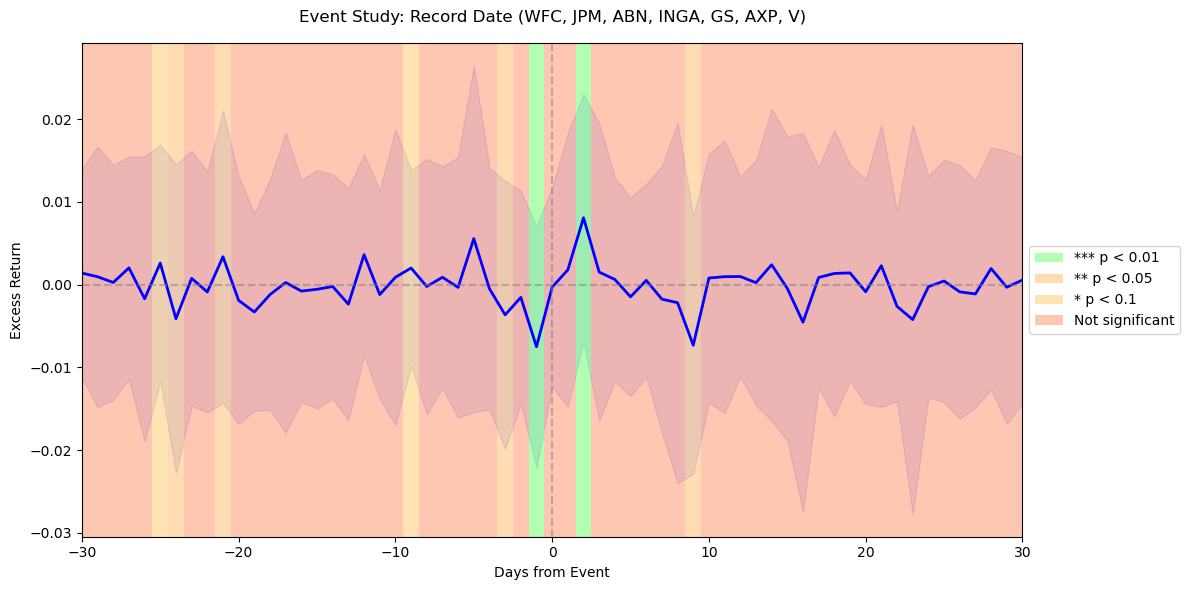




Analyzing Announce Date for WFC, JPM, ABN, INGA, GS, AXP, V...

Successfully processed 7 companies: WFC, JPM, ABN, INGA, GS, AXP, V

Event Study Summary (announce_date):
Number of events: 123
Number of companies: 7

Highly Significant Results (p < 0.01):
No highly significant results found


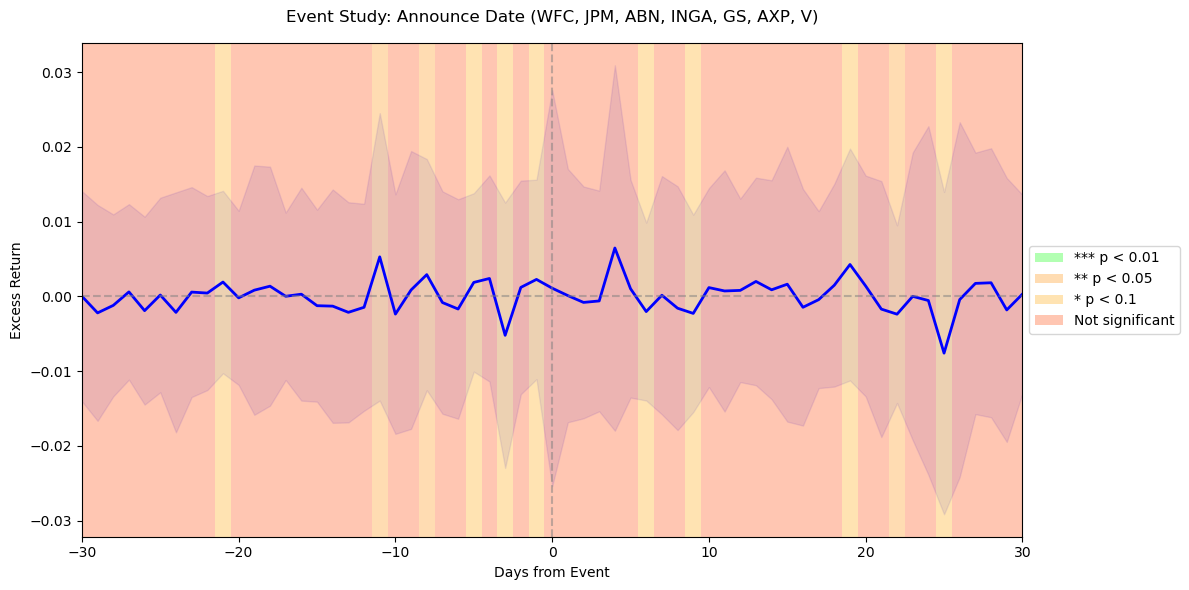




Analyzing Ex Div Date for WFC, JPM, ABN, INGA, GS, AXP, V...

Successfully processed 7 companies: WFC, JPM, ABN, INGA, GS, AXP, V

Event Study Summary (ex_div_date):
Number of events: 122
Number of companies: 7

Highly Significant Results (p < 0.01):
Day 0: -0.93% [-2.60%, 0.74%]
  t-stat: -6.50, p-value: 0.0000
--------------------------------------------------


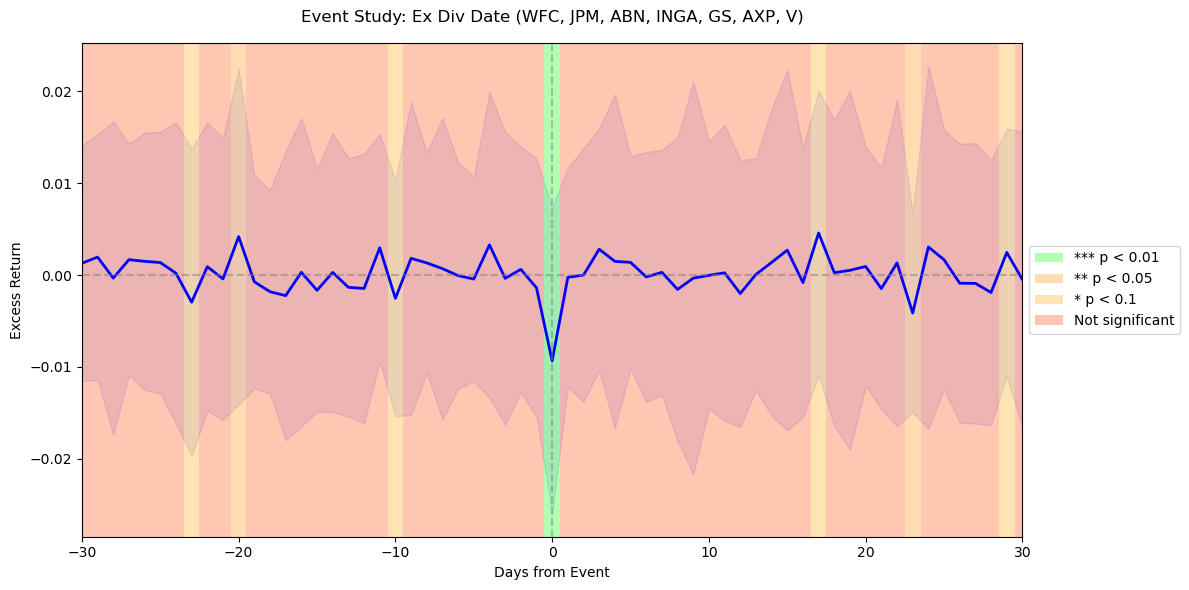




Analyzing Pay Date for WFC, JPM, ABN, INGA, GS, AXP, V...

Successfully processed 7 companies: WFC, JPM, ABN, INGA, GS, AXP, V

Event Study Summary (pay_date):
Number of events: 122
Number of companies: 7

Highly Significant Results (p < 0.01):
No highly significant results found


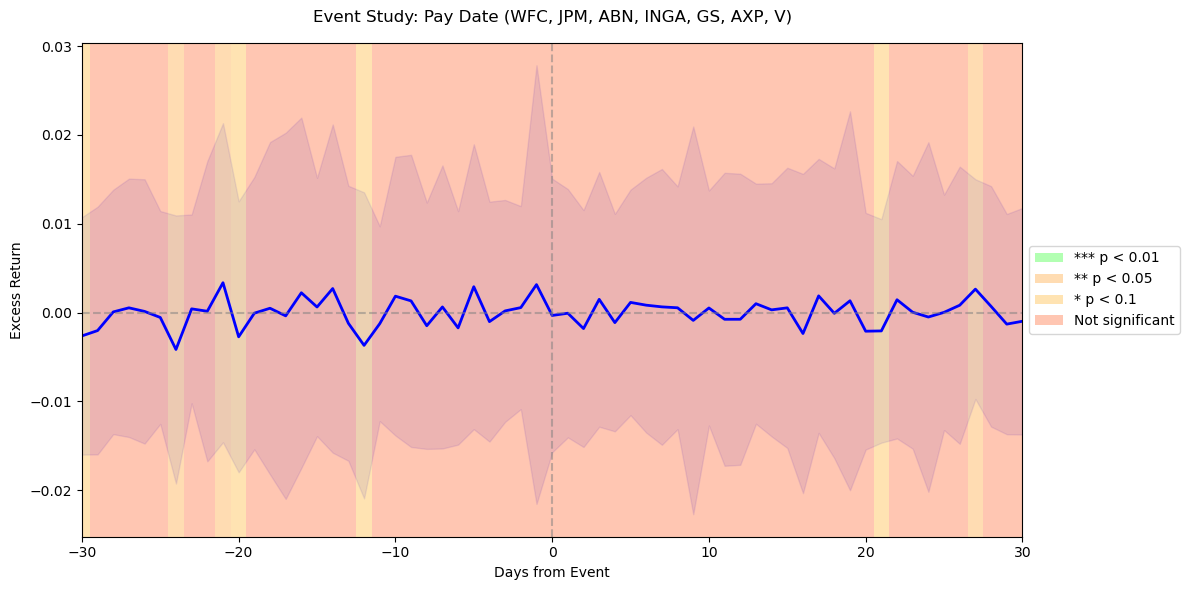

In [98]:
financial_stocks = ['WFC', 'JPM', 'ABN', 'INGA', 'GS', 'AXP', 'V']

analyze_stocks_events(financial_stocks, data_loader=global_loader)